In [9]:
from config import *
from dac_distance_map import DAC
from utils import *
from scipy.ndimage import binary_dilation
from skimage.exposure import match_histograms
from torchstain import MacenkoNormalizer
from staintools import StainNormalizer
import pandas as pd
import tifffile
import matplotlib.pyplot as plt
normalizer = MacenkoNormalizer(backend='numpy')

normalizer.HERef = np.array([[0.47262014, 0.17700575],
                             [0.79697804, 0.84033483],
                             [0.37610664, 0.51235373]])
normalizer.maxCRef = np.array([1.43072807, 0.98501085])

path_images = os.path.join(path_data,'images')
path_masks = os.path.join(path_data,'masks')
annotations = pd.read_csv(os.path.join(path_annotations,'annotations.csv'), index_col=0)
contour_inits = np.load(os.path.join(path_data, 'contour_init.npy'), allow_pickle=True).item()
all_filenames = np.unique(list(annotations['image']))
filename = all_filenames[0]
filename = np.unique(list(annotations['image']))[1]
annotations = annotations[annotations['term'] == 'dilated_tubule']
annotations = annotations[annotations['image'] == filename]
annotations.shape


(49, 7)

In [2]:
# annotations = pd.read_csv(os.path.join(path_annotations,'annotations.csv'), index_col=0)
# annotations = annotations.replace(['dilated_tubule','fake_tubule'], [1,0])
# dt_annotations = annotations[['image','term']].groupby('image').sum()
# dt_annotations.columns = ['number of dilated tubules']
# all_annotations = annotations[['image','term']].groupby('image').count()
# all_annotations.columns = ['number of annotations']

# dataset_stats = pd.concat([dt_annotations,all_annotations], axis = 1)
# dataset_stats['number of false dilated_tubule'] = dataset_stats['number of annotations'] - dataset_stats['number of dilated tubules']
# dataset_stats['image'] = dataset_stats.index
# dataset_stats = dataset_stats.reset_index(drop = True)
# dataset_stats['image'] = dataset_stats['image'].apply(lambda x: x.split('.')[0])
# dataset_stats
# # dataset_stats['image'] = dataset_stats.index.apply(lambda x : x.split('.')[0])

# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(font_scale=1)

# plt.figure(figsize = (10,10))
# # plotting columns

# ax = sns.barplot(x=dataset_stats['image'],
#                  y=dataset_stats['number of annotations'],
#                  color = np.array([207,105,138])/255,
#                  label = 'n° of annotations')

# ax = sns.barplot(x=dataset_stats['image'],
#                  y=dataset_stats['number of dilated tubules'],
#                  color = np.array([137,44,80])/255,
#                  label = 'n° of dilated tubules')
 
# # renaming the axes
# ax.set_xlabel("Slide",fontsize = 20)
# ax.set_ylabel("N° of instances",fontsize = 20)
# plt.legend(fontsize = 20)

# # visualizing illustration
# plt.show()


In [3]:
def preprocess_contour(contour_init,
                       img,
                       AREA_LIMIT = 10000):                       
    img = cv2.fillPoly(np.zeros(img.shape[:-1]), [contour_init.astype(int)], 1)
    img = binary_closing(img,disk(11))      
    contour_init = np.squeeze(cv2.findContours(img.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0][0])
    return contour_init 


### Evalutation of the model 

In [16]:
from generate_annotations.delete_annotations import *

In [25]:
delete_annotations(2579186, 2578438)

INFO:cytomine.client:[GET] /server/ping | 200 OK
INFO:cytomine.client:[GET] [currentuser] CURRENT USER - 203283 : ahabis | 200 OK
INFO:cytomine.client:[GET] [annotation collection] 11 objects | 200 OK
INFO:cytomine.client:[DELETE] [annotation] 2598047 | 200 OK
INFO:cytomine.client:[DELETE] [annotation] 2597981 | 200 OK
INFO:cytomine.client:[DELETE] [annotation] 2597936 | 200 OK
INFO:cytomine.client:[DELETE] [annotation] 2597901 | 200 OK
INFO:cytomine.client:[DELETE] [annotation] 2597872 | 200 OK
INFO:cytomine.client:[DELETE] [annotation] 2597851 | 200 OK
INFO:cytomine.client:[DELETE] [annotation] 2597832 | 200 OK
INFO:cytomine.client:[DELETE] [annotation] 2597799 | 200 OK
INFO:cytomine.client:[DELETE] [annotation] 2597764 | 200 OK
INFO:cytomine.client:[DELETE] [annotation] 2597739 | 200 OK
INFO:cytomine.client:[DELETE] [annotation] 2597713 | 200 OK


'You deleted all the annnotations'

In [26]:
120+91+87+82+61+37+30+28+26+24+22+22+18+17+17

682

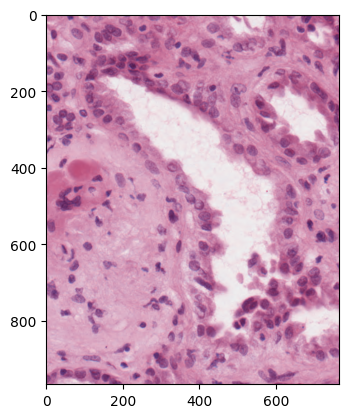

In [10]:
annotations = pd.read_csv(os.path.join(path_annotations,'annotations.csv'), index_col=0)
# 20163_2667263.tif
row = annotations[annotations['image'] == '20163.svs']
row = row.iloc[14]
filename_img = row_to_filename(row)
filename_img = '20163_2667263.tif'
img_anchor = tifffile.imread(os.path.join(path_images,filename_img))
new_img,HE = normalizer.normalize(img_anchor)
plt.imshow(new_img)
mask_anchor = tifffile.imread(os.path.join(path_masks,filename_img))


In [11]:
dac = DAC(nb_points = 100,
        n_epochs = 300,
        nb_augment = 100,
        isolines = np.array([0., 1.]),
        learning_rate = 5e-2,
        clip = 1e-1,
        sigma = 5,
        weights = 0.9,
        exponential_decay = 0.999,
        thresh = 1e-2)

In [13]:
contour_anchor = np.squeeze(cv2.findContours(mask_anchor.astype(np.uint8),
                                 cv2.RETR_TREE,
                                 cv2.CHAIN_APPROX_SIMPLE)[0][0])

In [14]:
dac.fit(img_anchor,
        contour_anchor,
        augment = True)
        

 ... (more hidden) ...


/home/ahabis/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/ahabis/3-Deep_active_contour/dac_distance_map.py:195: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return torch.squeeze(F.conv1d(out, self.kernel[None, None, :], padding="same"))[


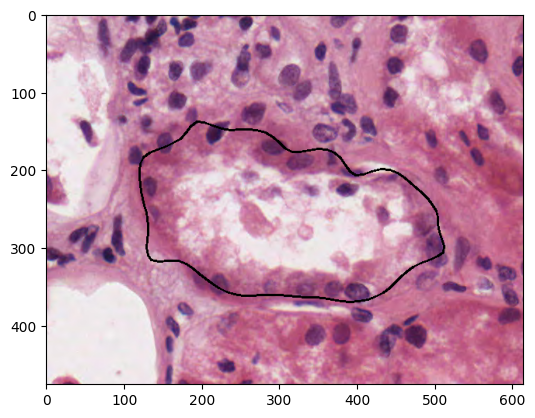

In [15]:
# filename_img = index_to_filename(annotations.index[8], annotations)
filename_img = '20163_2692503.tif'
img_test = tifffile.imread(os.path.join(path_images,filename_img))

contour_init = contour_inits[filename_img]
contour_init = preprocess_contour(contour_init,img_test)
shape_fin, score, tots, energies = dac.predict(img_test,
                                               contour_init)
tots[tots == 0] = 1e100
x = np.argmin(tots)
shape_to_display = (np.expand_dims(shape_fin[-1], 1)).astype(int)
new_img = cv2.drawContours((((img_test/np.max(img_test))*255).astype(np.uint8)).copy(),
                        [shape_to_display],
                        0,
                        color = 1,
                        thickness=2)

plt.imshow(new_img)
plt.show()


In [ ]:
plt.imshow(img_test)
plt.show()

In [ ]:
def adjust_saturation(img, new_saturation = 80.):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    saturation = img[:, :, 1].mean()    new_saturation = saturation

    img[:,:,1] = new_saturation * img[:,:,1]/saturation
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return img


In [ ]:
ener = np.squeeze(energies.cpu().detach().numpy())                                                
isolines = dac.isolines.cpu().detach().numpy()

for scale in range(5):
    for index, isoline in enumerate(isolines):
        plt.plot(np.arange(dac.n_epochs),ener[:,scale,index],label = 'isoline '+str(isoline))
    plt.title('evolution of the energies at scale: ' +str(scale+1))
    plt.xlabel('step')
    plt.ylabel('energie value')
    plt.legend()
    plt.show()


### Eval on a WSI

In [ ]:
tree = ET.parse(filename+'.xml')
root = tree.getroot()

In [ ]:
# # Get rough thresholded dilations
# slide, labels, stats = get_dilation_candidates(slide_path, debug=False)
# # Select the ones with appropriate size
# label_values, stats = select_by_size(stats, min_area=1e3, max_area=(1e5)/2)
# # Extract the patches at max resolution
# patch_list = get_candidate_patches(slide, label_values, stats, margin=150)

In [ ]:
def get_all_coordinates():
    
    coords = []
    for roi in root.iter('roi'):
        if roi[11].text == 'dilated_tubule':
            tmp = roi[12].itertext()

            l = []            
            for u in tmp:
                u = u.replace(' ','')
                u = u.replace('\n','')
                if u!= '':
                    l.append(float(u))
            coord = np.array(l).reshape((-1,2))
            coords.append(coord)

    return coords
def get_coordinates(j, 
                    margin =100,
                    im = im,
                    root = root):
    count = 0
    for roi in root.iter('roi'):
        if roi[11].text == 'dilated_tubule':
            tmp = roi[12].itertext()
            count+=1
            if count == j:
                break;
    l = []            
    for u in tmp:
        u = u.replace(' ','')
        u = u.replace('\n','')
        if u!= '':
            l.append(float(u))
    coord = np.array(l).reshape((-1,2))
    coord_min = coord - np.min(coord,0)
    
    x_min,y_min =  np.min(coord,0).astype(int) - margin
    x_max,y_max =  np.max(coord,0).astype(int) + margin
    
    img = np.array(im.read_region(location = [x_min, y_min],
                                  level = 0,
                                  size = [x_max - x_min,y_max - y_min]))
    x_ = dac.dim /np.flip(np.array(img.shape[:-1]))
    contour = ((coord_min+margin)*x_).astype(int)
    img = cv2.resize(img, dsize = (dac.dim,dac.dim), interpolation=cv2.INTER_AREA)[:,:,:-1]
    return img, contour

def retrieve_img_contour(index = None,
                         img_to_process = None,
                         only_find_white2 = True,
                         mask = np.ones((512,512)).astype(int)):

    if only_find_white == True:
        img = img_to_process
    else : 
        img = np.array(patch_list[index])
    img = img / np.max(img)
    img = np.clip(cv2.resize(img, (512,512), interpolation=cv2.INTER_AREA),0,1)

    mean = np.mean(img,-1)
    
    l, c = np.array(img.shape[:-1])//2

    lab = label(binary_opening(mean>0.78, disk(2)))

    uniques, counts = np.unique(lab, return_counts = True)
    lab[np.isin(lab, uniques[counts<300])] = 0
    mask_lab = 512 * np.logical_or((lab<=0), (1 - mask))
    distance = np.sqrt(np.sum((np.stack(np.meshgrid(np.arange(512),np.arange(512))).T - np.array([l,c]))**2,-1))
    a = mask_lab  +  distance
    white = (lab == lab.flatten()[np.argmin(a)]).astype(int)   
    shapes = cv2.findContours(white.astype(np.uint8), 
            method = cv2.RETR_TREE,
            mode=cv2.CHAIN_APPROX_SIMPLE,
            )[0]
    
    return img, np.squeeze(shapes[0])  

In [ ]:
img, contour_init = retrieve_img_contour(10, only_find_white=False)
shape_fin, scores,tots = dac.predict(img,contour_init)
x,y = np.divmod(np.argmax(scores), dac.n_run) 
score = np.max(scores)
shape_to_display = (np.expand_dims(shape_fin[y,x], 1)).astype(int)
new_img = cv2.drawContours((((img/np.max(img))*255).astype(np.uint8)).copy(),
                        [shape_to_display],
                        0,
                        color = 1,
                        thickness=2)
plt.imshow(new_img)
plt.show()

In [ ]:
index_test = 328
img = images[index_test]/255
contour_init = coordinates_start[index_test]

shape_fin, scores, tots, energies = dac.forward(img,
                                                contour_init)

tots[tots == 0] = 1e10
x,y = np.divmod(np.argmin(tots), dac.n_run)
score = np.max(scores)
shape_to_display = (np.expand_dims(shape_fin[y,x], 1)).astype(int)
new_img = cv2.drawContours((((img/np.max(img))*255).astype(np.uint8)).copy(),
                        [shape_to_display],
                        0,
                        color = 1,
                        thickness=2)

In [ ]:
import matplotlib
cmap = matplotlib.cm.get_cmap('seismic')

colors = [cmap(u)[:-1] for u in np.linspace(0,1,dac.n_epochs+1)]
colors = (np.array(colors)*255).astype(np.int32).tolist()

tots = []
imgs = []

for i, shape in enumerate(shape_fin):

    shape_to_display = (np.expand_dims(shape, 1)).astype(int)
    
    new_img = cv2.drawContours((((img_test/np.max(img_test))*255).astype(np.uint8)).copy(),
                               [shape_to_display],
                               0,
                               color = colors[i],
                               thickness=3)
    plt.imsave(os.path.join('folder_images_paper','image'+str(i)+'.jpg'),new_img)
    

In [ ]:
np.random.randint(0,800,50)

In [ ]:
imgs = []
scs = []


for i in tqdm(np.random.randint(100,700,50)):

    img = images[i]/255
    contour_init = coordinates_start[i]
    concentrations_ = concentrations[i]

    area = cv2.drawContours((img*255).astype(np.uint8).copy(),
                            [contour_init.astype(int)],
                            0,
                            color = 1,
                            thickness=2)


    contour_init = preprocess_contour(contour_init)
    shape_fin, score, tots, energies = dac.forward(img,
                                                    contour_init,
                                                    concentrations_)

    scs.append(np.array(score))
    y,x = x,y = np.divmod(np.argmin(tots), dac.n_run) 
    shape_to_display = (np.expand_dims(shape_fin[y,x], 1)).astype(int)
    new_img = cv2.drawContours((((img/np.max(img))*255).astype(np.uint8)).copy(),
                           [shape_to_display],
                           0,
                           color = 1,
                           thickness=2)
    imgs.append(new_img)

In [ ]:
scss = np.stack(scs)

In [ ]:
scss

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

l = len(imgs)
w = 10
h = 10
fig = plt.figure(figsize=(20, 10))
columns = 10
rows = l//columns

t = 0.716

for i in range(1, columns*rows +1):
    
    fig.add_subplot(rows, columns, i)
    plt.imshow(imgs[i - 1])
    plt.axis('off')
    sc = np.round(np.min(scs,1)[i-1],2)
    if sc >= t:
        color = 'g'
        text ='this is a tubule'
    else: 
        color = 'r'
        text ='this is a tubule'

    plt.title('Score = {}%'.format(100 * sc), y=-0.2, color = color)
    
plt.show()

In [ ]:
import  torch.nn.functional as F
from scipy.interpolate import interp1d



def interpolate(shape,
                n,
                margin = 20):

    top = shape[:margin]
    bot = shape[-margin:]
    new_shape = np.concatenate([bot,shape,top])

    distance = np.cumsum( np.sqrt(np.sum( np.diff(new_shape, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]
    k = new_shape.shape[0]
    alpha = np.linspace(distance[margin], distance[-margin], n)
    out =  interp1d(distance, new_shape, kind='cubic', axis=0)(alpha)
    return out

def define_kernel(kernel_size,
                  gaussian_sigma):

    mil = kernel_size//2
    filter = np.arange(kernel_size) - mil
    x = np.exp((-1/2)*(filter**2)/(2*(gaussian_sigma)**2))

    return torch.tensor(x/np.sum(x), dtype=float, device='cuda')

def convolve(x,
             kernel):

    margin = int(30)
    top = x[-margin:]
    bot = x[:margin]
    out = torch.concatenate([top,x,bot]).T[:,None]
    return torch.squeeze(F.conv1d(out, kernel[None,None,:],padding='same'))[:,margin:-margin]